# Описание проекта
Цель проекта: необходимо проанализировать поведение пользователей мобильного приложения стартапа, который продает продукты питания.

Задачи проекта:
* Изучить воронку продаж - узнать, как пользователи доходят до покупки;
* Исследовать результаты A/A/B-эксперимента - дизайнеры хотят поменять шрифты во всём приложении. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Нужно выяснить, какой шрифт лучше.

Файл для работы `logs_exp.csv` содержит действия пользователя - события.

Описание файла:

* EventName — название события;
* DeviceIDHash — уникальный идентификатор пользователя;
* EventTimestamp — время события;
* ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

# Подготовка и предобработка данных

In [ ]:
# импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats as st

In [ ]:
# прочитаем файл с данными и сохраненим в переменную
try:
    data = pd.read_csv('logs_exp.csv', sep='\t')
except:
    data = pd.read_csv('/datasets/logs_exp.csv', sep='\t')

In [ ]:
display(data.head())

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


Все названия столбцов начинаются с прописной буквы, а также отсутствует разделительное нижнее подчеркивание. Необходимо привести названия к корректному виду.

In [ ]:
# приведем названия столбцов к нижнему регистру
data.columns = (
    data.columns
    .str.lower()
)
display(data.head())

,eventname,deviceidhash,eventtimestamp,expid
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [ ]:
# приведем названия столбцов к змеиному регистру
data = data.rename(
    columns={
        'eventname': 'event_name',
        'deviceidhash': 'device_id_hash',
        'eventtimestamp': 'event_timestamp',
        'expid': 'exp_id'
    }
)
display(data.head())

,event_name,device_id_hash,event_timestamp,exp_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [ ]:
# выведем общую информацию датафрейма
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   event_name       244126 non-null  object
 1   device_id_hash   244126 non-null  int64 
 2   event_timestamp  244126 non-null  int64 
 3   exp_id           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [ ]:
# проверим на наличие пропусков
data.isna().sum()

,0
event_name,0
device_id_hash,0
event_timestamp,0
exp_id,0


In [ ]:
# проверим на наличие явных дубликатов
data.duplicated().sum()

413

In [ ]:
# найдем долю дубликатов от общего кол-ва строк
(data.duplicated().sum() / len(data) * 100).round(2)

0.17

In [ ]:
# избавимся от дубликатов (доля составляет меньше 5%)
data = (
    data
    .drop_duplicates()
    .reset_index(drop=True)
)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   event_name       243713 non-null  object
 1   device_id_hash   243713 non-null  int64 
 2   event_timestamp  243713 non-null  int64 
 3   exp_id           243713 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.4+ MB


In [ ]:
# изменим тип данных
data['event_timestamp'] = pd.to_datetime(data['event_timestamp'], unit='s')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       243713 non-null  object        
 1   device_id_hash   243713 non-null  int64         
 2   event_timestamp  243713 non-null  datetime64[ns]
 3   exp_id           243713 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 7.4+ MB


In [ ]:
# добавим столбец с датой
data['event_date'] = pd.to_datetime(data['event_timestamp'].dt.date)
display(data.head())

,event_name,device_id_hash,event_timestamp,exp_id,event_date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       243713 non-null  object        
 1   device_id_hash   243713 non-null  int64         
 2   event_timestamp  243713 non-null  datetime64[ns]
 3   exp_id           243713 non-null  int64         
 4   event_date       243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 9.3+ MB


In [ ]:
# проверим датафрейм на попадание пользователей в несколько групп
exp_check = (
    data
    .groupby('device_id_hash')['exp_id'].nunique()
    .reset_index()
    .sort_values(by='exp_id', ascending=False)
)
exp_check

,device_id_hash,exp_id
0,6888746892508752,1
5030,6207768971558512760,1
5042,6217807653094995999,1
5041,6217295124800833842,1
5040,6216080220799726690,1
...,...,...
2513,3175239243679501019,1
2512,3171891164497446149,1
2511,3171454373076660766,1
2510,3170212200647575044,1


Нет ни одного пользователя, состоящего сразу в нескольких экспериментальных группах.

**Вывод:** по итогу предобработки данных все датафреймы были приведены к корректному виду - названия столбцов соответствуют общепринятому виду, а типы данных соответствуют содержимому столбцов. Пропуски отсутствуют, а дубликаты были удалены, так как их доля составляет меньше 5% (0,17%). Таким образом, можно приступать к дальнейшему исследованию.

# Изучим данные

In [ ]:
# найдем количество событий в логе
event_count = data['event_name'].count()
event_count

243713

In [ ]:
# найдем количество пользователей в логе
user_count = data['device_id_hash'].nunique()
user_count

7551

In [ ]:
# найдем среднее количество событий на одного пользователя
event_per_user = (event_count / user_count).round(0)
event_per_user

32.0

In [ ]:
total_event_per_user = (
    data
    .groupby('device_id_hash')
    .agg({'event_name': 'count'})
    .sort_values(by='event_name', ascending=False)
    .reset_index()
)
display(total_event_per_user)

,device_id_hash,event_name
0,6304868067479728361,2307
1,197027893265565660,1998
2,4623191541214045580,1768
3,6932517045703054087,1439
4,1754140665440434215,1221
...,...,...
7546,7399061063341528729,1
7547,2968164493349205501,1
7548,8071397669512236988,1
7549,425817683219936619,1


Некоторые пользователи совершили более 1000 событий! Также есть те, кто выполнил максимум одно.

In [ ]:
# найдем минимальную дату
data['event_date'].min()

Timestamp('2019-07-25 00:00:00')

In [ ]:
# найдем максимальную дату
data['event_date'].max()

Timestamp('2019-08-07 00:00:00')

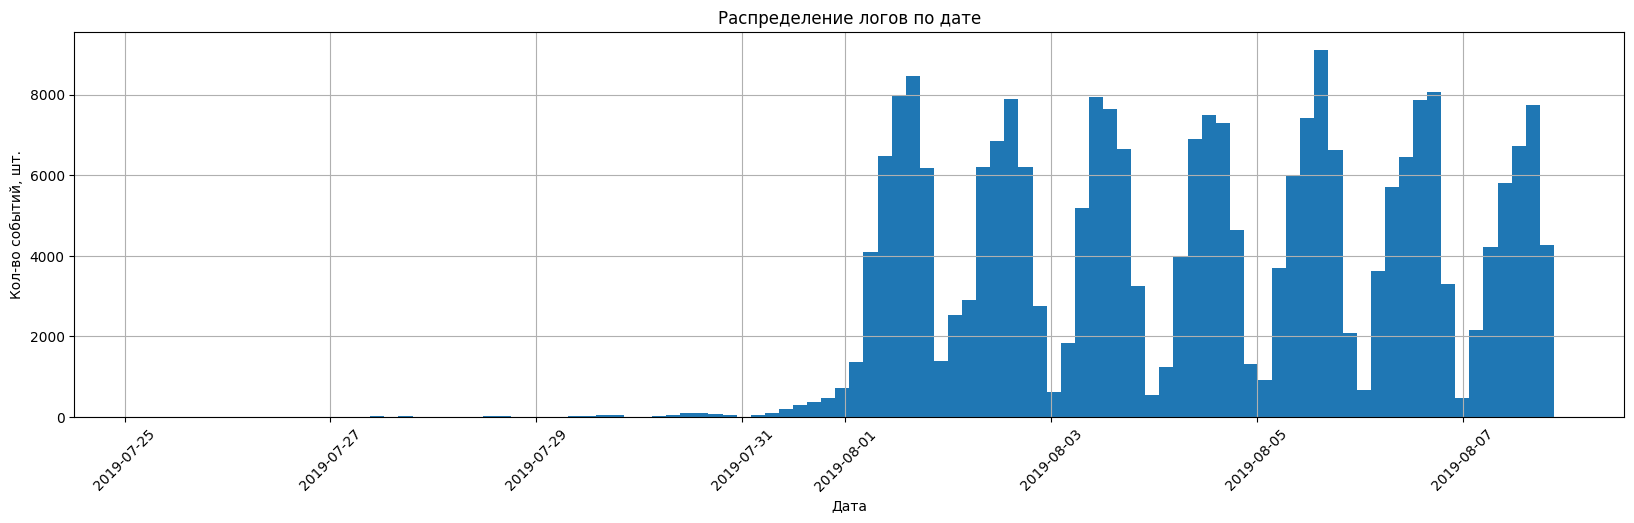

In [ ]:
# построим гистограмму по дате
data['event_timestamp'].hist(
    bins=100,
    figsize=(20, 5)
)
plt.title('Распределение логов по дате')
plt.xlabel('Дата')
plt.ylabel('Кол-во событий, шт.')
plt.xticks(rotation=45)
plt.show()

По гистограмме видно, что основная часть данных от 1 августа 2019. Необходимо сделать срез, чтобы в датафрейме содержались полные данные за весь период.

In [ ]:
# отбросим данные до 1 августа
new_data = data[data['event_timestamp'] >= '2019-08-01']
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 240887 entries, 2826 to 243712
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       240887 non-null  object        
 1   device_id_hash   240887 non-null  int64         
 2   event_timestamp  240887 non-null  datetime64[ns]
 3   exp_id           240887 non-null  int64         
 4   event_date       240887 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 11.0+ MB


In [ ]:
new_data.head()

,event_name,device_id_hash,event_timestamp,exp_id,event_date
2826,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01
2827,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01
2828,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01
2829,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01
2830,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01


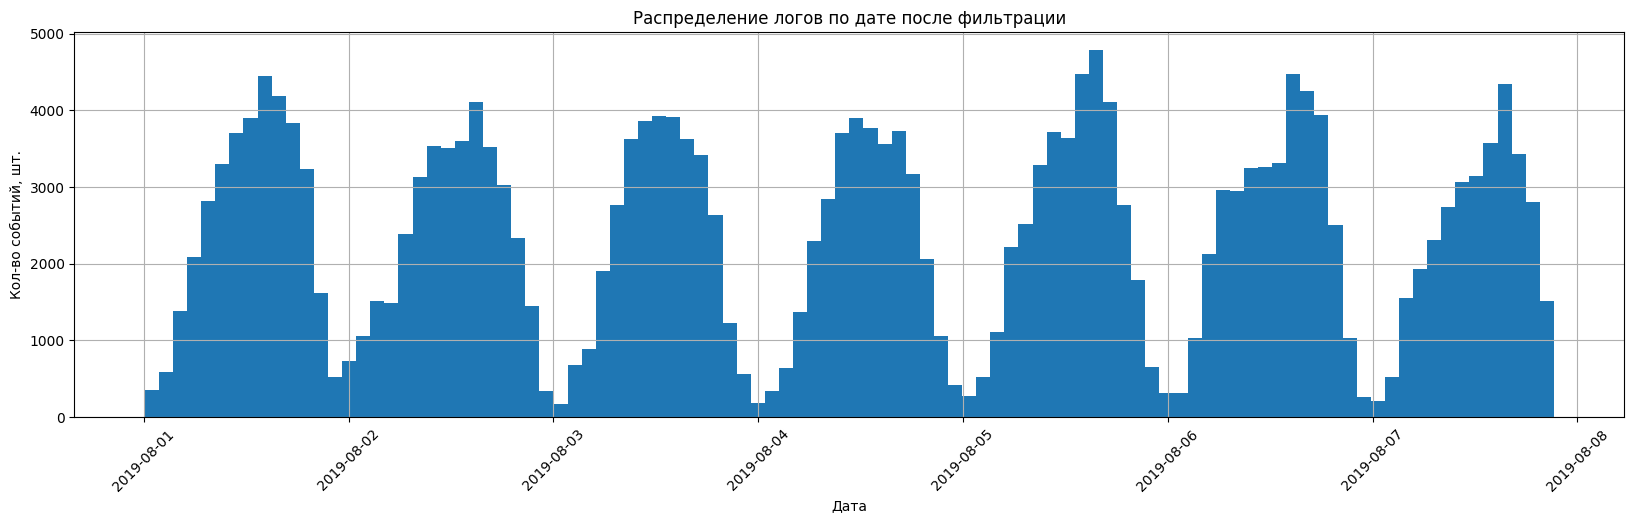

In [ ]:
# построим гистограмму по дате после фильтрации
new_data['event_timestamp'].hist(
    bins=100,
    figsize=(20, 5)
)
plt.title('Распределение логов по дате после фильтрации')
plt.xlabel('Дата')
plt.ylabel('Кол-во событий, шт.')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# найдем насколько изменился размер датафрейма
size_old_data = len(data)
size_new_data = len(new_data)
diff_data = size_new_data / size_old_data * 100
diff_data

98.8404393692581

In [ ]:
# найдем насколько уменьшилось количество событий
event_count_new = new_data['event_name'].count()
diff_event = event_count - event_count_new
print(f'Количество событий уменьшилось на {diff_event}')
diff_event_percent = round(event_count_new / event_count * 100, 2)
print(f'Количество событий составляет {diff_event_percent}% от исходного датафрейма')

Количество событий уменьшилось на 2826
Количество событий составляет 98.84% от исходного датафрейма


In [ ]:
# найдем насколько уменьшилось количество пользователей
user_count_new = new_data['device_id_hash'].nunique()
diff_user = user_count - user_count_new
diff_user
print(f'Количество пользователей уменьшилось на {diff_user}')
diff_user_percent = round(user_count_new / user_count * 100, 2)
print(f'Количество пользователей составляет {diff_user_percent}% от исходного датафрейма')

Количество пользователей уменьшилось на 17
Количество пользователей составляет 99.77% от исходного датафрейма


In [ ]:
# найдем количество уникальных пользоваталей во всех группах
new_data.groupby('exp_id').agg(
    {'device_id_hash': 'nunique'}
)

,device_id_hash
exp_id,
246,2484
247,2513
248,2537


# Изучим воронку событий

In [ ]:
# найдем какие события есть в логе и как часто они встречаются
events = (
    new_data
    .groupby('event_name')
    .agg({'device_id_hash': 'count'})
    .rename(columns={'device_id_hash' : 'total_events'})
    .sort_values(by='total_events', ascending=False)
    .reset_index()
)
events

,event_name,total_events
0,MainScreenAppear,117328
1,OffersScreenAppear,46333
2,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


In [ ]:
# найдем долю пользователей, которые совершили хотя бы одно событие
users = (
    new_data
    .groupby('event_name')
    .agg({'device_id_hash': 'nunique'})
    .rename(columns={'device_id_hash' : 'total_users'})
    .sort_values(by='total_users', ascending=False)
    .reset_index()
)
users['percent'] = (users['total_users'] / new_data['device_id_hash'].nunique() * 100).round(2)
users

,event_name,total_users,percent
0,MainScreenAppear,7419,98.47
1,OffersScreenAppear,4593,60.96
2,CartScreenAppear,3734,49.56
3,PaymentScreenSuccessful,3539,46.97
4,Tutorial,840,11.15


Пользователи чаще всего взаимодействовали с главным экраном (98%), при этом практически никто не запускал обучение - всего 11%.

В результате, можно составить следующую последовательность действий пользователей:

1. Открытие приложения (пользователь попадает на главный экран);
2. Переход в каталог предложений;
3. Открытие карточки товара;
4. Переход на экран с подтверждением успешной оплаты.

In [ ]:
users['funnel'] =  (users['total_users'].pct_change() + 1).round(2)
users = users.head(-1)
users

,event_name,total_users,percent,funnel
0,MainScreenAppear,7419,98.47,NaN
1,OffersScreenAppear,4593,60.96,0.62
2,CartScreenAppear,3734,49.56,0.81
3,PaymentScreenSuccessful,3539,46.97,0.95


In [ ]:
# найдем количество пользователей, которая дошла от первого события до оплаты
pay_users = (users['total_users'].iloc[3] / users['total_users'].iloc[0] * 100).round(2)
pay_users

47.7

**Вывод:** изучив воронку событий, можно точно оценить цепочку событий и действий пользователя. В результате мы узнали, что только 62% пользователей переходили в каталог предложений. При этом, после того, как товар был добавлен в корзину, вероятность оплаты заказа составляет 95%, а почти 50% пользователей дошли от первого события до оплаты. Обучение просмотрело всего 11% пользователей - он не влияет на конверсию в покупку.

# Изучим результаты эксперимента

In [ ]:
# найдем количество пользователей в каждой экспериментальной группе
users_in_exp_group = (
    new_data
    .groupby('exp_id')
    .agg(count=('device_id_hash', 'nunique'))
)
users_in_exp_group

,count
exp_id,
246,2484
247,2513
248,2537


Сформулируем гипотезы:
* H0: доля пользователей, перешедших на этап воронки, одинаковы;
* H1: доля пользователей, перешедших на этап воронки, отличаются.

Уроверь статистической значимости примем 0,05. Чтобы снизить вероятность ложнопозитивного результата при множественном тестировании гипотез, применим методы корректировки уровня значимости для уменьшения вероятности ошибки первого рода - метод Бонферрони.

Для сравнения двух средних значений генеральной совокупности, применим z-тест.

In [ ]:
# удалим Tutorial из датафрейма
new_data = new_data.query('event_name != "Tutorial"')
new_data.head()

,event_name,device_id_hash,event_timestamp,exp_id,event_date
2827,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01
2828,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01
2829,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01
2830,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01
2831,MainScreenAppear,4899590676214355127,2019-08-01 00:10:15,247,2019-08-01


In [ ]:
# создадим функцию для сравнения групп
def z_test(df1, df2, event, n):

    alpha = 0.05

    # критический уровень статистической значимости c поправкой Бонферрони
    bonferroni_alpha = alpha / n

    # число пользователей, совершивших событие в группе 1 и группе 2
    successes = np.array([df1[df1['event_name'] == event]['device_id_hash'].nunique(),
                        df2[df2['event_name'] == event]['device_id_hash'].nunique()])

    # число пользователей в группе 1 и группе 2:
    n_users = np.array([df1['device_id_hash'].nunique(),
                        df2['device_id_hash'].nunique()])

    # пропорции успехов в группах:
    p1 = successes[0]/n_users[0]
    p2 = successes[1]/n_users[1]

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (n_users[0] + n_users[1])

    # разница пропорций в датасетах
    difference = p1 - p2

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference /  np.sqrt(p_combined * (1 - p_combined) * (1/n_users[0] + 1/n_users[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2   #тест двусторонний, удваиваем результат

    print('Событие:', event)
    print('P-value:', p_value)

    if p_value < bonferroni_alpha:
        print('Отвергаем нулевую гипотезу')
    else:
        print(
        'Не получилось отвергнуть нулевую гипотезу')

In [ ]:
# проверим, есть ли статистически значимая разница между контрольными группами 246 и 247:

for event in new_data['event_name'].unique():
    z_test(new_data[new_data['exp_id'] == 246], new_data[new_data['exp_id'] == 247], event, 4)
    print()

Событие: MainScreenAppear
P-value: 0.7526703436483038
Не получилось отвергнуть нулевую гипотезу

Событие: OffersScreenAppear
P-value: 0.24786096925282264
Не получилось отвергнуть нулевую гипотезу

Событие: CartScreenAppear
P-value: 0.22867643757335676
Не получилось отвергнуть нулевую гипотезу

Событие: PaymentScreenSuccessful
P-value: 0.11446627829276612
Не получилось отвергнуть нулевую гипотезу



Между группами 246 и 247 нет статистически значимых различий при заданном уровне значимости, поэтому можно приступить к A/B-тестированию.

In [ ]:
# проверим, есть ли статистически значимая разница между контрольными группами 246 и 248:

for event in new_data['event_name'].unique():
    z_test(new_data[new_data['exp_id'] == 246], new_data[new_data['exp_id'] == 248], event, 12)
    print()

Событие: MainScreenAppear
P-value: 0.3387114076159288
Не получилось отвергнуть нулевую гипотезу

Событие: OffersScreenAppear
P-value: 0.21442476639710506
Не получилось отвергнуть нулевую гипотезу

Событие: CartScreenAppear
P-value: 0.08067367598823139
Не получилось отвергнуть нулевую гипотезу

Событие: PaymentScreenSuccessful
P-value: 0.21693033984516674
Не получилось отвергнуть нулевую гипотезу



Между группами 246 и 248 нет статистически значимых различий при заданном уровне значимости.

In [ ]:
# проверим, есть ли статистически значимая разница между контрольными группами 247 и 248:

for event in new_data['event_name'].unique():
    z_test(new_data[new_data['exp_id'] == 247], new_data[new_data['exp_id'] == 248], event, 12)
    print()

Событие: MainScreenAppear
P-value: 0.5194964354051703
Не получилось отвергнуть нулевую гипотезу

Событие: OffersScreenAppear
P-value: 0.9333751305879443
Не получилось отвергнуть нулевую гипотезу

Событие: CartScreenAppear
P-value: 0.5878284605111943
Не получилось отвергнуть нулевую гипотезу

Событие: PaymentScreenSuccessful
P-value: 0.7275718682261119
Не получилось отвергнуть нулевую гипотезу



Между группами 246 и 248 также не обнаружились статистически значимые различий при заданном уровне значимости.

In [ ]:
# проверим есть ли статистически значимая разница между объединённой контрольной и экпериментальной 248 группами:

for event in new_data['event_name'].unique():
    z_test(new_data[new_data['exp_id'] != 248], new_data[new_data['exp_id'] == 248], event, 12)
    print()

Событие: MainScreenAppear
P-value: 0.3486684291093256
Не получилось отвергнуть нулевую гипотезу

Событие: OffersScreenAppear
P-value: 0.44582745409482394
Не получилось отвергнуть нулевую гипотезу

Событие: CartScreenAppear
P-value: 0.18683558686831558
Не получилось отвергнуть нулевую гипотезу

Событие: PaymentScreenSuccessful
P-value: 0.6107918742187335
Не получилось отвергнуть нулевую гипотезу



Между объединённой контрольной и экпериментальной группами различий не обнаружено.

# Общий вывод

В ходе работы было проанализировано поведение пользователей мобильного приложения стартапа, который продает продукты питания, на основании логов пользователей, а затем проведено A/A/B-тестирование для сравнения групп.

Первым делом была проведена предобработка данных, результатом которой предоставленные датасеты были приведены к корректному виду, а также были исправлены типы данных в столбцах.

При изучении данных, было обнаружено, что датасет не является полным за весь период - был сделан срез, чтобы новый датафрейм содержал только полные и равномерно распределенные данные - для проверки была построена гистограмма.

Затем была рассмотрена воронка событий, по итогам которой была определена цепочка событий:

1. Открытие приложения (пользователь попадает на главный экран) - 98% дошло до этого этапа;
2. Переход в каталог предложений - 61% пользователей;
3. Открытие карточки товара - 50% пользователей;
4. Переход на экран с подтверждением успешной оплаты - 47% пользователей.

При этом, только 11-12% пользователей смотрят обучающий ролик, следовательно, он не влияет на переход к экрану оплаты.

Также было проанализировано сколько пользователей теряется на каждом этапе:

1. Только 62% переходит с главного экрана в каталог предложений;
2. 81% пользователей открывают карточку товара из каталога;
3. Оплату из корзины успешно производят 95% пользователей.

Заключительной часть исследования был анализ A/A/B-теста. Сначала нужно было сравнить одинаковые выборки - A/A-тест - чтобы удостовериться в корректности расчета. В группах 246 и 247 не обнаружено статистической значимой разницы по всем этапам - можно переходить к A/B-тесту.

В A/B-тест были сравнены все события 246 и 247 групп с контрольной группой 248 - во всех тестах нет статистически значимой разницы. Таким образом, можно сделать вывод, что изменение шрифтов в приложении не привело к увеличению конверсии в оплаты товара - на поведение пользователей изменение не повлияло.